_Neural Data Science_

Lecturer: Dr. Jan Lause, Prof. Dr. Philipp Berens

Tutors: Jonas Beck, Fabio Seel, Julius Würzler

Summer term 2025

Student names: <span style='background: yellow'>Aakarsh Nair, Andreas Kotzur, Ahmed Eldably</span>

LLM Disclaimer: <span style='background: yellow'>
Google Gemini , Google Gemini Diffiusion - Planning, Coding, and Verification.</span>

# Coding Lab 7 : Transcriptomics

In [7]:
import numpy as np
import pylab as plt
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")

# We recommend using openTSNE for experiments with t-SNE
# https://github.com/pavlin-policar/openTSNE
from openTSNE import TSNE

%matplotlib inline

%load_ext jupyter_black

%load_ext watermark
%watermark --time --date --timezone --updated --python --iversions --watermark -p sklearn

The jupyter_black extension is already loaded. To reload it, use:
  %reload_ext jupyter_black
The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark
Last updated: 2025-06-08 19:02:52CEST

Python implementation: CPython
Python version       : 3.11.11
IPython version      : 9.2.0

sklearn: 1.6.1

numpy     : 1.26.4
openTSNE  : 1.0.2
matplotlib: 3.9.4
seaborn   : 0.13.2
pandas    : 2.2.3

Watermark: 2.5.0



In [2]:
plt.style.use("../matplotlib_style.txt")

# Introduction

In this notebook you are going to work with transcriptomics data, in particular single-cell RNA sequencing (scRNA-seq) data from the paper by [Harris et al. (2018)](https://journals.plos.org/plosbiology/article?id=10.1371/journal.pbio.2006387). They recorded the transcriptomes of 3,663 inhibitory cells in the hippocampal area CA1. Their analysis divided these cells into 49 fine-scale clusters coresponding to different cell subtypes. They asigned names to these cluster in a hierarchical fashion according to strongly expressed gene in each clusters. The figure below shows the details of their classification. 

You will first analyze some of the most relevant statistics of UMI gene counts distributions, and afterwards follow the standard pipeline in the field to produce a visualization of the data.

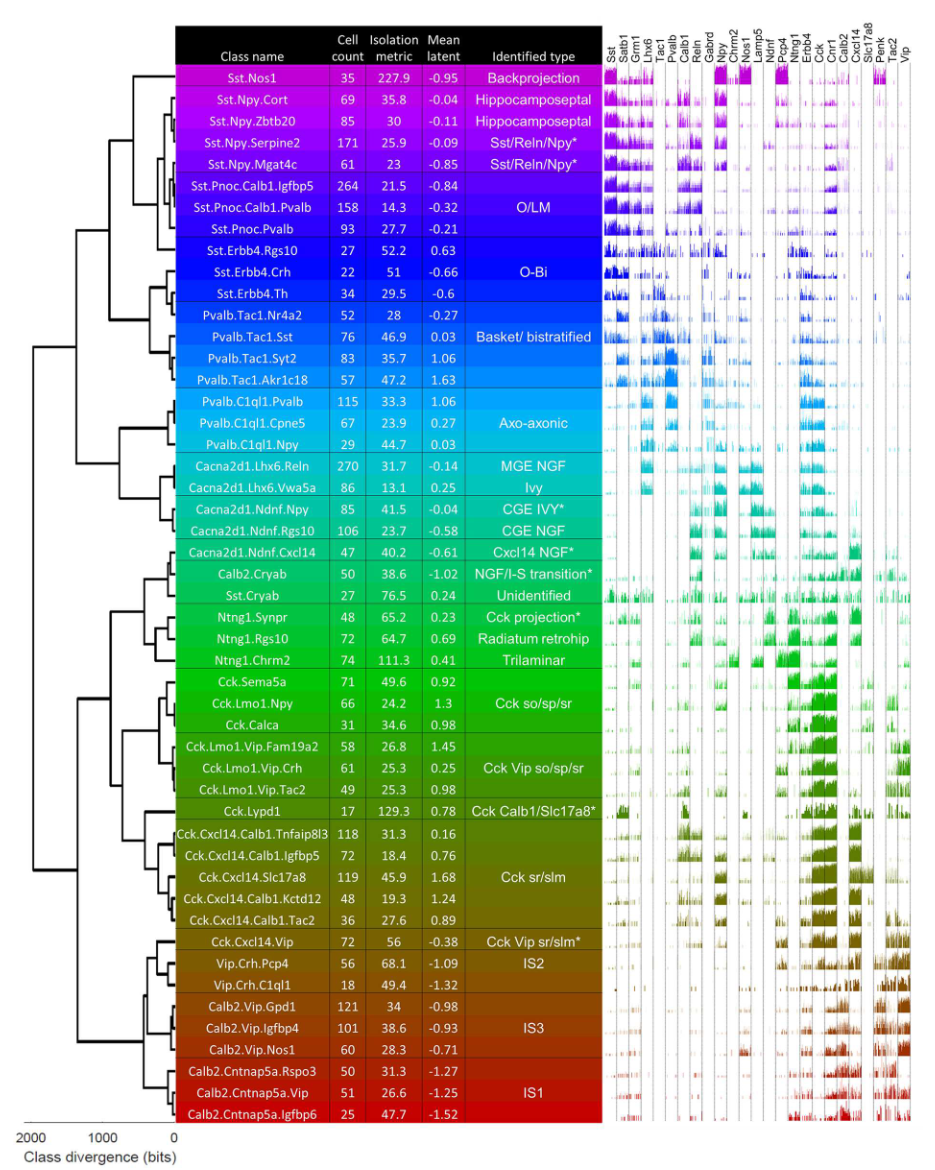

## Load data

Download the data from ILIAS, move it to the `data/` directory and unzip it there.
The read counts can be found in `counts`, with rows corresponding to cells and columns to genes.
The cluster assignments for every individual cell can be found in  `clusters`, along with the colors used in the publication in  `clusterColors`.

In [3]:
# LOAD HARRIS ET AL DATA

# Load gene counts
data = pd.read_csv("../data/nds_cl_7/harris-data/expression.tsv", sep="\t")
genes = data.values[:, 0]
cells = data.columns[1:-1]
counts = data.values[:, 1:-1].transpose().astype("int")
data = []

# Kick out all genes with all counts = 0
genes = genes[counts.sum(axis=0) > 0]
counts = counts[:, counts.sum(axis=0) > 0]
print(counts.shape)

# Load clustering results
data = pd.read_csv("../data/nds_cl_7/harris-data/analysis_results.tsv", sep="\t")
clusterNames, clusters = np.unique(data.values[0, 1:-1], return_inverse=True)

# Load cluster colors
data = pd.read_csv("../data/nds_cl_7/harris-data/colormap.txt", sep="\s+", header=None)
clusterColors = data.values

# Note: the color order needs to be reversed to match the publication
clusterColors = clusterColors[::-1]

# Taken from Figure 1 - we need cluster order to get correct color order
clusterOrder = [
    "Sst.No",
    "Sst.Npy.C",
    "Sst.Npy.Z",
    "Sst.Npy.S",
    "Sst.Npy.M",
    "Sst.Pnoc.Calb1.I",
    "Sst.Pnoc.Calb1.P",
    "Sst.Pnoc.P",
    "Sst.Erbb4.R",
    "Sst.Erbb4.C",
    "Sst.Erbb4.T",
    "Pvalb.Tac1.N",
    "Pvalb.Tac1.Ss",
    "Pvalb.Tac1.Sy",
    "Pvalb.Tac1.A",
    "Pvalb.C1ql1.P",
    "Pvalb.C1ql1.C",
    "Pvalb.C1ql1.N",
    "Cacna2d1.Lhx6.R",
    "Cacna2d1.Lhx6.V",
    "Cacna2d1.Ndnf.N",
    "Cacna2d1.Ndnf.R",
    "Cacna2d1.Ndnf.C",
    "Calb2.Cry",
    "Sst.Cry",
    "Ntng1.S",
    "Ntng1.R",
    "Ntng1.C",
    "Cck.Sema",
    "Cck.Lmo1.N",
    "Cck.Calca",
    "Cck.Lmo1.Vip.F",
    "Cck.Lmo1.Vip.C",
    "Cck.Lmo1.Vip.T",
    "Cck.Ly",
    "Cck.Cxcl14.Calb1.Tn",
    "Cck.Cxcl14.Calb1.I",
    "Cck.Cxcl14.S",
    "Cck.Cxcl14.Calb1.K",
    "Cck.Cxcl14.Calb1.Ta",
    "Cck.Cxcl14.V",
    "Vip.Crh.P",
    "Vip.Crh.C1",
    "Calb2.Vip.G",
    "Calb2.Vip.I",
    "Calb2.Vip.Nos1",
    "Calb2.Cntnap5a.R",
    "Calb2.Cntnap5a.V",
    "Calb2.Cntnap5a.I",
]

reorder = np.zeros(clusterNames.size) * np.nan
for i, c in enumerate(clusterNames):
    for j, k in enumerate(clusterOrder):
        if c[: len(k)] == k:
            reorder[i] = j
            break
clusterColors = clusterColors[reorder.astype(int)]

(3663, 17965)


# Task 1: Data inspection
Before we use t-SNE or any other advanced visualization methods on the data, we first want to have a closer look on the data and plot some statistics. For most of the analysis we will compare the data to a Poisson distribution.

###  1.1. Relationship between expression mean and fraction of zeros
Compute actual and predicted gene expression. The higher the average expression of a gene, the smaller fraction of cells will show a 0 count. Plot the data and explain what you see in the plot.


_(3 pts)_

In [8]:
# ------------------------------------------------------
# Compute actual and predicted gene expression (1 pt)
# ------------------------------------------------------

# Compute the average expression for each gene
gene_means = np.mean(counts, axis=0)

# Compute the fraction of zeros for each gene
n_cells = counts.shape[0]
frac_zeros = (counts == 0).sum(axis=0) / n_cells

In [9]:
# Compute the Poisson prediction
# (what is the expected fraction of zeros in a Poisson distribution with a given mean?)
poisson_pred = np.exp(-gene_means)
poisson_pred

array([0.91784928, 0.99945415, 0.99972704, ..., 0.4146063 , 0.92640843,
       0.99809082])

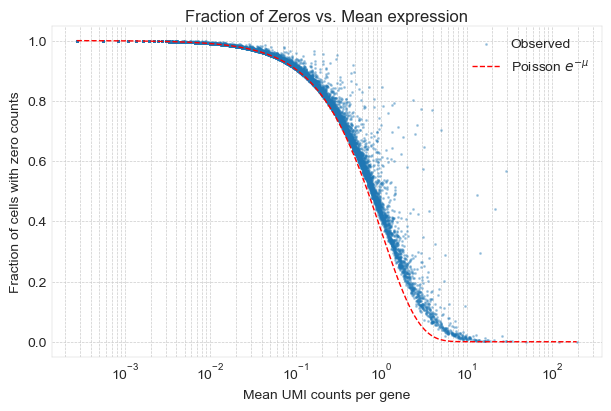

In [ ]:
# --------------------------------------------------
# plot the data and the Poisson prediction (1 pt)
# --------------------------------------------------

fig, ax = plt.subplots(figsize=(6, 4))

# scatter observed mean vs zero‐fraction
ax.scatter(gene_means, frac_zeros, s=5, alpha=0.3, label="Observed")

# plot Poisson curve (sorted for a smooth line)
idx = np.argsort(gene_means)
ax.plot(gene_means[idx], poisson_pred[idx], "r--", lw=1, label=r"Poisson $e^{-\mu}$")

# Here we chose not to scale the y-axis logarithmically.
ax.set_xscale("log")
ax.set_xlabel("Mean UMI counts per gene")
ax.set_ylabel("Fraction of cells with zero counts")
ax.grid(True, which="both", linestyle="--", linewidth=0.5)

ax.legend()
ax.set_title("Fraction of Zeros vs. Mean expression")
plt.savefig("../images/lab7-mean_vs_fraction_zeros.png", dpi=300, bbox_inches="tight")

plt.show()

_Explanation (1 pt)_

### Gene mean vs zero-fraction plot

For each gene we plot its mean UMI count ($\mu$) against the fraction of cells with zero counts.  
The red curve shows the Poisson expectation  

\[
P(X = 0) = e^{-\mu}.
\]

* **Low expression** ($\mu \ll 1$) — points trace the curve, indicating sampling noise alone.  
* **Higher expression** ($\mu \gtrsim 1$) — points lie **above** $e^{-\mu}$; the excess zeros arise from technical drop-outs and true biological heterogeneity, producing **overdispersion / zero-inflation** beyond Poisson.

Hence single-cell RNA-seq counts are better modelled with a negative-binomial or zero-inflated negative-binomial distribution that captures both the mean–variance dependence and the elevated zero rate.


### 1.2. Mean-variance relationship

If the expression follows Poisson distribution, then the mean should be equal to the variance. Plot the mean-variance relationship and interpret the plot.

_(2.5 pts)_

In [17]:
# -------------------------------------------------------------------
# Compute the variance of the expression counts of each gene (0.5 pt)
# -------------------------------------------------------------------
gene_vars = np.var(counts, axis=0)
gene_vars

array([1.49899881e-01, 5.45702429e-04, 2.72925744e-04, ...,
       1.24532529e+00, 8.20630026e-02, 1.90734998e-03])

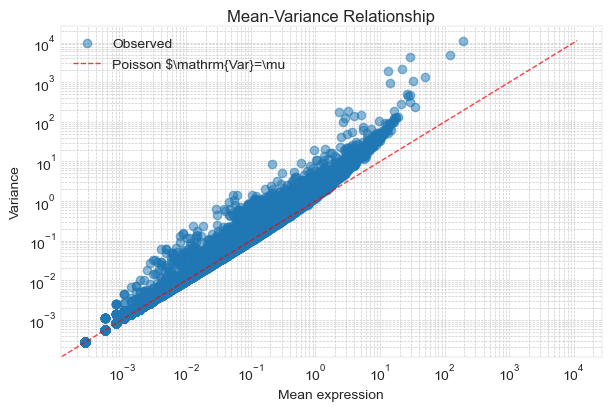

In [23]:
# -------------------------------------------------------------
# Plot the mean-variance relationship on a log-log plot (1 pt)
# Plot the Poisson prediction as a line
# -------------------------------------------------------------

fig, ax = plt.subplots(figsize=(6, 4))
plt.plot(gene_means, gene_vars, "o", alpha=0.5, label="Observed")
lims = [
    np.min([plt.xlim(), plt.ylim()]),  # find the min of the axes
    np.max([plt.xlim(), plt.ylim()]),  # find the max of the axes
]
# Plot the y=x line
plt.plot(lims, lims, "r--", alpha=0.75, label="Poisson $\mathrm{Var}=\mu")

plt.xscale("log")
plt.yscale("log")
plt.xlabel("Mean expression")
plt.ylabel("Variance")
plt.title("Mean-Variance Relationship")
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.legend()
plt.savefig("../images/lab7-mean_vs_variance.png", dpi=300, bbox_inches="tight")
plt.show()

_Explanation (1 pt)_
...

### 1.3. Relationship between the mean and the Fano factor

Compute the Fano factor for each gene and make a scatter plot of expression mean vs. Fano factor in log-log coordinates, and interpret what you see in the plot. If the expression follows the Poisson distribution, then the Fano factor (variance/mean) should be equal to 1 for all genes.

_(2.5 pts)_

In [24]:
# --------------------------------------------
# Compute the Fano factor for each gene (0.5 pt)
# --------------------------------------------

fano = gene_vars / gene_means
fano

array([1.74867282, 0.999454  , 0.999727  , ..., 1.41445784, 1.07355992,
       0.998089  ])

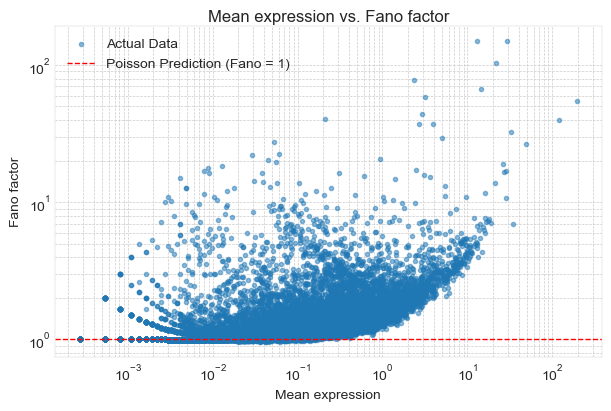

In [ ]:
# -------------------------------
# plot fano-factor vs mean (1 pt)
# incl. fano factor
# -------------------------------
# Plot a Poisson prediction as line
# Use the same style of plot as above.

fig, ax = plt.subplots(figsize=(6, 4))

plt.scatter(gene_means, fano, alpha=0.5, label="Observed")
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Mean expression")
plt.ylabel("Fano factor")
plt.title("Mean expression vs. Fano factor")
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.axhline(y=1, color="red", linestyle="--", label="Poisson Prediction (Fano = 1)")
plt.legend()
plt.savefig("../images/lab7-mean_vs_fano.png", dpi=300, bbox_inches="tight")
plt.show()

_Explanation (1 pt)_
...

### 1.4. Histogram of sequencing depths

Different cells have different sequencing depths (sum of counts across all genes) because the efficiency can change from droplet to droplet due to some random expreimental factors. Make a histogram of sequencing depths.

_(1.5 pts)_

In [27]:
# -------------------------------
# Compute sequencing depth (0.5 pt)
# -------------------------------
depths = counts.sum(axis=1)
depths

array([ 1662,  2087,  2524, ...,  9924, 10558,  9492])

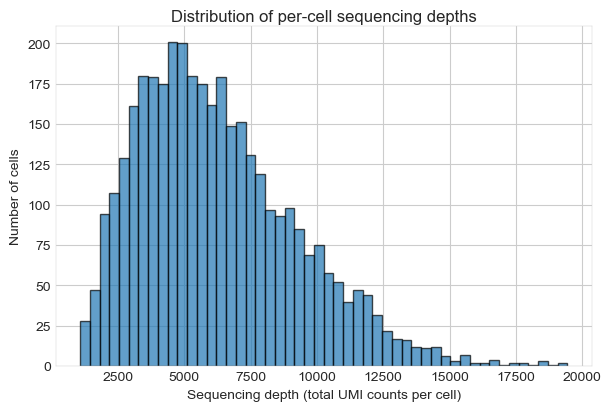

In [29]:
# ------------------------------------------
# Plot histogram of sequencing depths (1 pt)
# ------------------------------------------

fig, ax = plt.subplots(figsize=(6, 4))

# choose a reasonable number of bins, e.g. 50
ax.hist(depths, bins=50, edgecolor="black", alpha=0.7)

ax.set_xlabel("Sequencing depth (total UMI counts per cell)")
ax.set_ylabel("Number of cells")
ax.set_title("Distribution of per-cell sequencing depths")
plt.show()

### 1.5. Fano factors after normalization

Normalize counts by the sequencing depth of each cell and multiply by the median sequencing depth. Then make the same expression vs Fano factor plot as above. After normalization by sequencing depth, Fano factor should be closer to 1 (i.e. variance even more closely following the mean). This can be used for feature selection.

_(2.5 pts)_

In [30]:
# -------------------------------------------------
# compute normalized counts and fano factor (1 pt)
# -------------------------------------------------
# depths has shape (n_cells,)
median_depth = np.median(depths)

# normalize each cell to the median depth
counts_norm = counts / depths[:, None] * median_depth

# recompute mean & variance per gene on normalized data
gene_means_norm = counts_norm.mean(axis=0)
gene_vars_norm = counts_norm.var(axis=0)

# fano factor after normalization
fano_norm = gene_vars_norm / gene_means_norm

fano_norm

array([1.4743044 , 1.64107479, 1.01368967, ..., 1.81740881, 1.18732466,
       0.78672188])

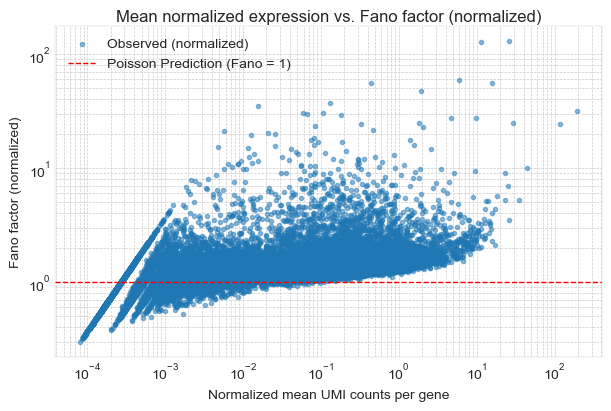

In [32]:
# ----------------------------------------------------------
# plot normalized counts and find the top 10 genes (1 pt)
# hint: keep appropriate axis scaling in mind
# ----------------------------------------------------------

fig, ax = plt.subplots(figsize=(6, 4))
# add plot
plt.scatter(gene_means_norm, fano_norm, alpha=0.5, label="Observed (normalized)")
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Normalized mean UMI counts per gene")
plt.ylabel("Fano factor (normalized)")
plt.title("Mean normalized expression vs. Fano factor (normalized)")
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.axhline(y=1, color="red", linestyle="--", label="Poisson Prediction (Fano = 1)")
plt.legend()
plt.savefig("../images/lab7-mean_vs_fano_normalized.png", dpi=300, bbox_inches="tight")
plt.show()

In [36]:
# --------------------------------------------------------------------
# Find top-10 genes with the highest normalized Fano factor (0.5 pts)
# Print them sorted by the Fano factor starting from the highest
# Gene names are stored in the `genes` array
# --------------------------------------------------------------------
top10_idx = np.argsort(fano_norm)[::-1][:10]


# print gene names and their normalized Fano factors
print("Top 10 genes with the highest normalized Fano factor:")
for i in top10_idx:
    print(f"{genes[i]:<15}  Fano={fano_norm[i]:.2f}")

Top 10 genes with the highest normalized Fano factor:
Sst              Fano=131.14
Npy              Fano=128.40
Vip              Fano=59.11
Cck              Fano=55.65
Cpne2            Fano=55.22
Pcp4             Fano=47.65
Ptpn23           Fano=37.25
Pdzd9            Fano=35.06
Malat1           Fano=31.42
Armc2            Fano=30.59


# Task 2: Low dimensional visualization

In this task we will construct a two dimensional visualization of the data. First we will normalize the data with some variance stabilizing transformation and study the effect that different approaches have on the data. Second, we will reduce the dimensionality of the data to a more feasible number of dimensions (e.g. $d=50$) using PCA. And last, we will project the PCA-reduced data to two dimensions using t-SNE.

### 2.1. PCA with and without transformations

Here we look at the influence of variance-stabilizing transformations on PCA. We will focus on the following transformations: 
- Square root (`sqrt(X)`): it is a variance-stabilizing transformation for the Poisson data. 
- Log-transform (`log2(X+1)`): it is also often used in the transcriptomic community. 

We will only work with the most important genes. For that, transform the counts into normalized counts (as above) and select all genes with normalized Fano factor above 3 and remove the rest. We will look at the effect that both transformations have in the PCA-projected data by visualizing the first two components. Interpret qualitatively what you see in the plot and compare the different embeddings making use of the ground truth clusters.

_(3.5 pts)_

In [37]:
# --------------------------------
# Select important genes (0.5 pts)
# --------------------------------

depths = counts.sum(axis=1)
counts_norm = counts / depths[:, None] * np.median(depths)

fano_norm = counts_norm.var(axis=0) / counts_norm.mean(axis=0)
hv_mask = fano_norm > 3
counts_sel = counts_norm[:, hv_mask]
genes_sel = genes[hv_mask]
print("Selected", counts_sel.shape[1], "highly variable genes")

Selected 707 highly variable genes


In [50]:
# --------------------------------------
# transform data and apply PCA (1 pt)
# --------------------------------------

from sklearn.decomposition import PCA

# perform PCA

raw_data = counts_sel
sqrt_data = np.sqrt(counts_sel)
log_data = np.log2(counts_sel + 1)

# 2. Fit PCA *and* keep both the model and the scores
pca_raw = PCA(n_components=50)
pc_raw = pca_raw.fit_transform(raw_data)

pca_sqrt = PCA(n_components=50)
pc_sqrt = pca_sqrt.fit_transform(sqrt_data)

pca_log = PCA(n_components=50)
pc_log = pca_log.fit_transform(log_data)

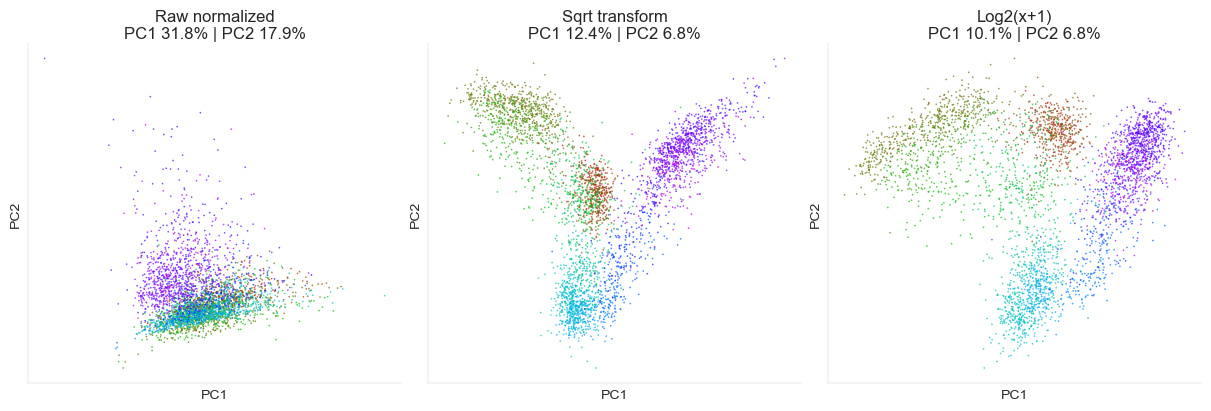

In [51]:
# ------------------------------------------------
# plot first 2 PCs for each transformation (1 pt)
# ------------------------------------------------

fig, axs = plt.subplots(1, 3, figsize=(12, 4), facecolor="white")
for ax, pca, pc, title in zip(
    axs,
    [pca_raw, pca_sqrt, pca_log],
    [pc_raw, pc_sqrt, pc_log],
    ["Raw normalized", "Sqrt transform", "Log2(x+1)"],
):
    v1, v2 = pca.explained_variance_ratio_[:2]
    ax.scatter(
        pc[:, 0], pc[:, 1], s=6, alpha=0.7, c=clusterColors[clusters], edgecolors="none"
    )
    ax.set_title(f"{title}\nPC1 {v1*100:.1f}% | PC2 {v2*100:.1f}%", fontsize=12)
    ax.set_xlabel("PC1")
    ax.set_ylabel("PC2")
    ax.set_xticks([])
    ax.set_yticks([])

    for side in ["top", "right"]:
        ax.spines[side].set_visible(False)

plt.show()

_Explanation (1 pt)_
...

### 2.2. tSNE with and without transformations

Now, we will reduce the dimensionality of the PCA-reduced data further to two dimensions using t-SNE. We will use only $n=50$ components of the PCA-projected data. Plot the t-SNE embedding for the three versions of the data and interpret the plots. Do the different transformations have any effect on t-SNE?

_(1.5 pts)_

In [67]:
# -----------------------
# Perform tSNE (0.5 pts)
# -----------------------
from openTSNE import TSNE

tsne_raw = TSNE(n_components=2, perplexity=30, random_state=0).fit(pc_raw)
tsne_sqrt = TSNE(n_components=2, perplexity=30, random_state=0).fit(pc_sqrt)
tsne_log = TSNE(n_components=2, perplexity=30, random_state=0).fit(pc_log)

In [ ]:
import numpy as np

# write all six to one file
np.savez_compressed(
    "embeddings_task2.npz",
    pca50_raw=pc_raw,
    pca50_sqrt=pc_sqrt,
    pca50_log=pc_log,
    tsne_raw=tsne_raw,
    tsne_sqrt=tsne_sqrt,
    tsne_log=tsne_log,
)

print("Saved PCA+TSNE embeddings to embeddings_task2.npz")

In [53]:
data = np.load("embeddings_task2.npz")
pc_raw = data["pca50_raw"]
pc_sqrt = data["pca50_sqrt"]
pc_log = data["pca50_log"]
tsne_raw = data["tsne_raw"]
tsne_sqrt = data["tsne_sqrt"]
tsne_log = data["tsne_log"]

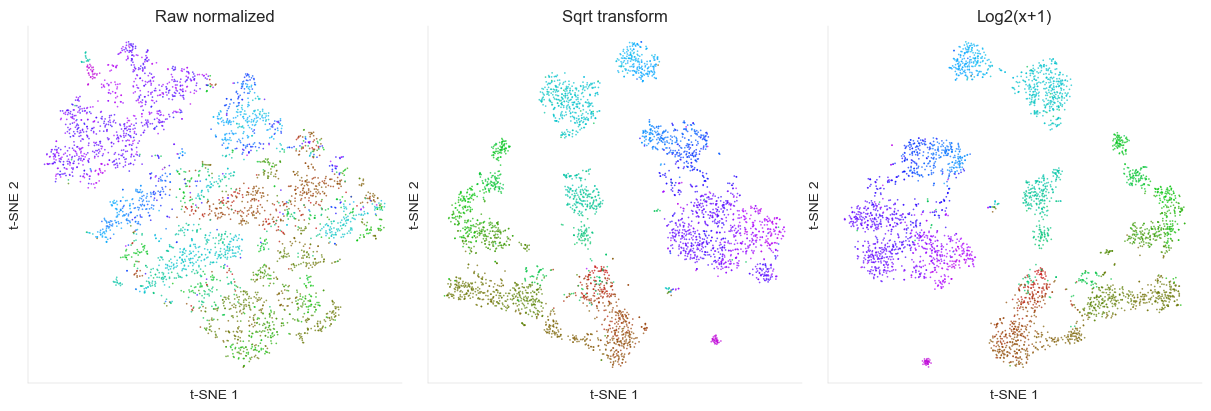

In [55]:
# -----------------------------------------------
# plot t-SNE embedding for each dataset (1 pt)
# -----------------------------------------------

fig, axs = plt.subplots(1, 3, figsize=(12, 4), facecolor="white")
for ax, emb, title in zip(
    axs,
    [tsne_raw, tsne_sqrt, tsne_log],
    ["Raw normalized", "Sqrt transform", "Log2(x+1)"],
):
    ax.scatter(
        emb[:, 0],
        emb[:, 1],
        s=6,
        alpha=0.7,
        c=clusterColors[clusters],
        edgecolors="none",
    )
    ax.set_title(title)
    ax.set_xlabel("t-SNE 1")
    ax.set_ylabel("t-SNE 2")
    ax.set_xticks([])
    ax.set_yticks([])
    for side in ["top", "right"]:
        ax.spines[side].set_visible(False)

plt.show()

### 2.3. Leiden clustering

Now we will play around with some clustering and see whether the clustering methods can produce similar results to the original clusters from the publication. We will apply Leiden clustering (closely related to the Louvain clustering), which is standard in the field and works well even for very large datasets. 

Choose one representation of the data (best transformation based in your results from the previous task) to use further in this task and justify your choice. Think about which level of dimensionality would be sensible to use to perform clustering. Visualize in the two-dimensional embedding the resulting clusters and compare to the original clusters. 

_(1.5 pts)_

In [56]:
# To run this code you need to install leidenalg and igraph
# conda install -c conda-forge python-igraph leidenalg

import igraph as ig
from sklearn.neighbors import NearestNeighbors, kneighbors_graph
import leidenalg as la

In [57]:
# Define some contrast colors

clusterCols = [
    "#FFFF00",
    "#1CE6FF",
    "#FF34FF",
    "#FF4A46",
    "#008941",
    "#006FA6",
    "#A30059",
    "#FFDBE5",
    "#7A4900",
    "#0000A6",
    "#63FFAC",
    "#B79762",
    "#004D43",
    "#8FB0FF",
    "#997D87",
    "#5A0007",
    "#809693",
    "#FEFFE6",
    "#1B4400",
    "#4FC601",
    "#3B5DFF",
    "#4A3B53",
    "#FF2F80",
    "#61615A",
    "#BA0900",
    "#6B7900",
    "#00C2A0",
    "#FFAA92",
    "#FF90C9",
    "#B903AA",
    "#D16100",
    "#DDEFFF",
    "#000035",
    "#7B4F4B",
    "#A1C299",
    "#300018",
    "#0AA6D8",
    "#013349",
    "#00846F",
    "#372101",
    "#FFB500",
    "#C2FFED",
    "#A079BF",
    "#CC0744",
    "#C0B9B2",
    "#C2FF99",
    "#001E09",
    "#00489C",
    "#6F0062",
    "#0CBD66",
    "#EEC3FF",
    "#456D75",
    "#B77B68",
    "#7A87A1",
    "#788D66",
    "#885578",
    "#FAD09F",
    "#FF8A9A",
    "#D157A0",
    "#BEC459",
    "#456648",
    "#0086ED",
    "#886F4C",
    "#34362D",
    "#B4A8BD",
    "#00A6AA",
    "#452C2C",
    "#636375",
    "#A3C8C9",
    "#FF913F",
    "#938A81",
    "#575329",
    "#00FECF",
    "#B05B6F",
    "#8CD0FF",
    "#3B9700",
    "#04F757",
    "#C8A1A1",
    "#1E6E00",
    "#7900D7",
    "#A77500",
    "#6367A9",
    "#A05837",
    "#6B002C",
    "#772600",
    "#D790FF",
    "#9B9700",
    "#549E79",
    "#FFF69F",
    "#201625",
    "#72418F",
    "#BC23FF",
    "#99ADC0",
    "#3A2465",
    "#922329",
    "#5B4534",
    "#FDE8DC",
    "#404E55",
    "#0089A3",
    "#CB7E98",
    "#A4E804",
    "#324E72",
    "#6A3A4C",
    "#83AB58",
    "#001C1E",
    "#D1F7CE",
    "#004B28",
    "#C8D0F6",
    "#A3A489",
    "#806C66",
    "#222800",
    "#BF5650",
    "#E83000",
    "#66796D",
    "#DA007C",
    "#FF1A59",
    "#8ADBB4",
    "#1E0200",
    "#5B4E51",
    "#C895C5",
    "#320033",
    "#FF6832",
    "#66E1D3",
    "#CFCDAC",
    "#D0AC94",
    "#7ED379",
    "#012C58",
]

clusterCols = np.array(clusterCols)

In [61]:
# ------------------------------------------------------
# create graph and run leiden clustering on it (0.5 pts)
# hint: use `la?`, `la.find_partition?` and `ig.Graph?`
# to find out more about the provided packages.
# ------------------------------------------------------

# Construct kNN graph with k=15


A = kneighbors_graph(pc_sqrt, n_neighbors=15, mode="connectivity", include_self=False)
src, tgt = A.nonzero()
g = ig.Graph(edges=list(zip(src, tgt)), directed=False)
g.simplify()
part = la.find_partition(g, la.RBConfigurationVertexPartition, resolution_parameter=1.0)
labels1 = np.array(part.membership)
print("Leiden r=1.0 →", len(np.unique(labels1)), "clusters")

Leiden r=1.0 → 14 clusters


ARI = 0.40


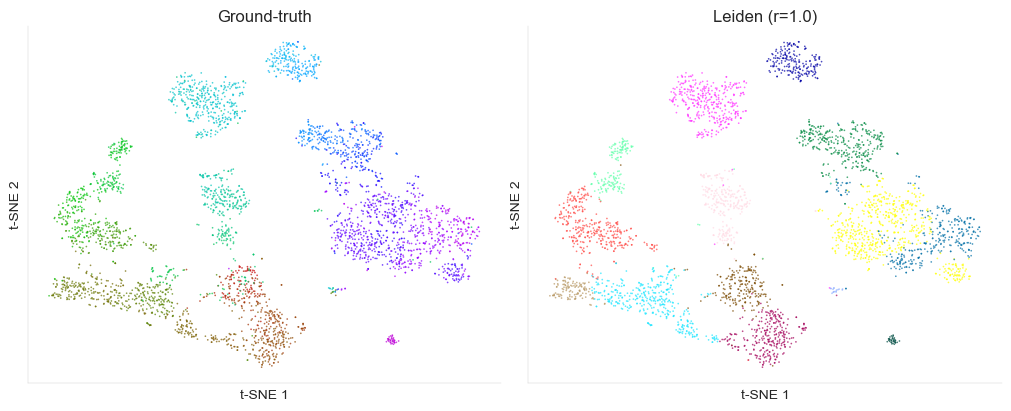

In [62]:
# --------------------------
# Plot the results (1 pt)
# --------------------------

from sklearn.metrics import adjusted_rand_score

fig, axs = plt.subplots(1, 2, figsize=(10, 4), facecolor="white")
for ax, labs, title in zip(
    axs, [clusters, labels1], ["Ground-truth", "Leiden (r=1.0)"]
):
    ax.scatter(
        tsne_sqrt[:, 0],
        tsne_sqrt[:, 1],
        s=6,
        alpha=0.7,
        c=(clusterColors if title == "Ground-truth" else clusterCols)[labs],
        edgecolors="none",
    )
    ax.set_title(title)
    ax.set_xlabel("t-SNE 1")
    ax.set_ylabel("t-SNE 2")
    ax.set_xticks([])
    ax.set_yticks([])
    for side in ["top", "right"]:
        ax.spines[side].set_visible(False)

ari = adjusted_rand_score(clusters, labels1)
print(f"ARI = {ari:.2f}")

### 2.4. Change the clustering resolution

The number of clusters can be changed by modifying the resolution parameter. How many clusters did we get with the default value? Change the resolution parameter to yield 2x more and 2x fewer clusters
Plot all three results as t-SNE overlays (same as above).

_(1.5 pts)_

In [63]:
# ------------------------------------------------------------------
# run the clustering for 3 different resolution parameters (0.5 pts)
# ------------------------------------------------------------------
res = [1.0, 0.5, 2.0]
labels = []
counts = []
for r in res:
    p = la.find_partition(g, la.RBConfigurationVertexPartition, resolution_parameter=r)
    labs = np.array(p.membership)
    labels.append(labs)
    counts.append(len(np.unique(labs)))
print(dict(zip(res, counts)))

{1.0: 13, 0.5: 10, 2.0: 21}


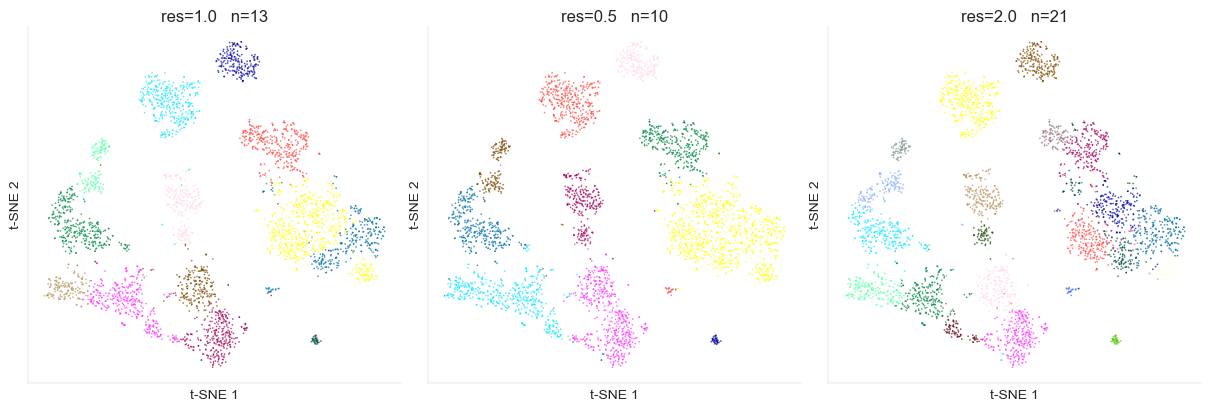

In [66]:
# --------------------------
# Plot the results (1 pt)
# --------------------------

fig, axs = plt.subplots(1, 3, figsize=(12, 4), facecolor="white")
# add plot
for ax, r, labs, cnt in zip(axs, res, labels, counts):
    ax.scatter(
        tsne_sqrt[:, 0],
        tsne_sqrt[:, 1],
        s=6,
        alpha=0.7,
        c=clusterCols[labs],
        edgecolors="none",
    )
    ax.set_title(f"res={r}   n={cnt}")
    ax.set_xlabel("t-SNE 1")
    ax.set_ylabel("t-SNE 2")
    ax.set_xticks([])
    ax.set_yticks([])
    for side in ["top", "right"]:
        ax.spines[side].set_visible(False)
plt.show()